In [1]:
import numpy as np
import torch
import gymnasium as gym
from gymnasium import spaces

import imageio
import os
import random

from Dueling_DQN_Agent.Dueling_DQN_Agent import Dueling_DQN_Agent
import Dueling_DQN_Agent.utils.help_classes as hc
import Dueling_DQN_Agent.utils.stats_functions as sf

import hockey.hockey_env as h_env

from importlib import reload


In [2]:
SEED_TRAIN_1 = 7489
SEED_TRAIN_2 = 1312
SEEDS_TEST = [291, 292, 293, 294, 295]

seed = SEED_TRAIN_1

In [3]:
env_name = "DuelingDQN_CartPole-v1_test"
env = gym.make("CartPole-v1", render_mode="rgb_array")
if isinstance(env.action_space, spaces.Box):
    env = hc.DiscreteActionWrapper(env,5)

# Initialize the agent with the correct state/action space
state_space = env.observation_space
action_space = env.action_space

#agent = Dueling_DQN_Agent(state_space, action_space, use_eps_decay = True, seed = seed)
#agent = Dueling_DQN_Agent(state_space, action_space, seed = seed, hidden_sizes = [256, 256, 128], value_hidden_sizes = [128,128], advantage_hidden_sizes = [128,128]) 
agent = Dueling_DQN_Agent(state_space, action_space, seed = seed) 

stats = []
losses = []

max_episodes = 4000
train_iterations = 32  # Number of training steps per episode

max_steps = 1000

for episode in range(max_episodes):

    state, _ = env.reset(seed = seed)
    state = state[0] if isinstance(state, tuple) else state  # Handle Gymnasium compatibility
    total_reward = 0
    
    for t in range(max_steps):

        done = False
        #a1 = env.discrete_to_continous_action(agent.perform_greedy_action(state))
        a1 = agent.perform_greedy_action(state)


        """print(f"a1: {a1}, shape: {np.asarray(a1).shape}")
        print(f"a2: {a2}, shape: {np.asarray(a2).shape}")
        print(f"full action: {full_action}, shape: {full_action.shape}")"""

        next_state, reward, done, truncated, _ = env.step(a1)
        
        total_reward += reward

        agent.buffer.add_transition((state, a1, reward, next_state, done))      # Store transition in the agent"s memory and then train

        state = next_state

        if done or truncated: break
        
    losses.extend(agent.train(train_iterations))
    stats.append([episode, total_reward, t + 1])
    
    if agent._config["use_eps_decay"] and episode > int(0.5 * max_episodes):
        agent._perform_epsilon_decay()

    print(f"Episode {episode+1}/{max_episodes}, Total Reward: {total_reward}")
        
    if ((episode) % int(max_episodes/10) == 0) and episode > 0:
        agent.Q.save(env_name, name = f"episode_{episode}")

agent.Q.save(env_name, name = "training_finished")
sf.save_stats(env_name, stats, losses)


Episode 1/4000, Total Reward: 8.0
Episode 2/4000, Total Reward: 8.0
Episode 3/4000, Total Reward: 8.0
Episode 4/4000, Total Reward: 10.0
Episode 5/4000, Total Reward: 9.0
Episode 6/4000, Total Reward: 8.0
Episode 7/4000, Total Reward: 8.0
Episode 8/4000, Total Reward: 10.0
Episode 9/4000, Total Reward: 12.0
Episode 10/4000, Total Reward: 10.0
Episode 11/4000, Total Reward: 10.0
Episode 12/4000, Total Reward: 10.0
Episode 13/4000, Total Reward: 12.0
Episode 14/4000, Total Reward: 10.0
Episode 15/4000, Total Reward: 10.0
Episode 16/4000, Total Reward: 10.0
Episode 17/4000, Total Reward: 10.0
Episode 18/4000, Total Reward: 10.0
Episode 19/4000, Total Reward: 10.0
Episode 20/4000, Total Reward: 8.0
Episode 21/4000, Total Reward: 10.0
Episode 22/4000, Total Reward: 10.0
Episode 23/4000, Total Reward: 8.0
Episode 24/4000, Total Reward: 8.0
Episode 25/4000, Total Reward: 8.0
Episode 26/4000, Total Reward: 8.0
Episode 27/4000, Total Reward: 8.0
Episode 28/4000, Total Reward: 8.0
Episode 29/400

Plot saved at DuelingDQN_CartPole-v1_test/stats/plots/returns_plot.png


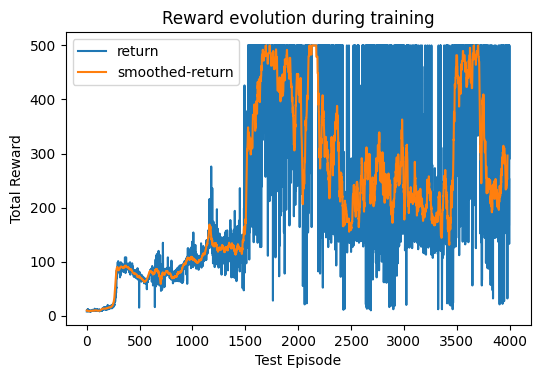

In [4]:
sf.plot_returns(stats, env_name)

Plot saved at DuelingDQN_CartPole-v1_test/stats/plots/losses_plot.png


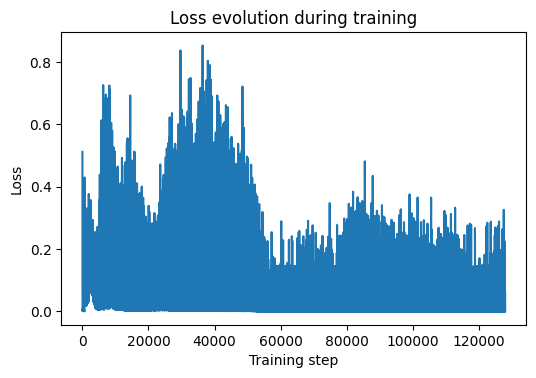

In [5]:
sf.plot_losses(losses, env_name)

## Testing the agent

Test Episode 1, Total Reward: 1000.0
Test Episode 2, Total Reward: 1000.0
Test Episode 3, Total Reward: 1000.0
Test Episode 4, Total Reward: 1000.0
Test Episode 5, Total Reward: 1000.0
Plot saved at DuelingDQN_CartPole-v1_test/stats/plots/test_results.png


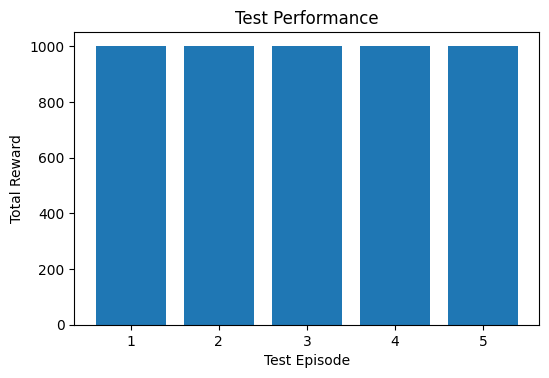

In [6]:
test_episodes = len(SEEDS_TEST)
test_rewards = []

max_steps = 1000

for episode in range(test_episodes):
    state = env.reset(seed = SEEDS_TEST[episode])
    state = state[0] if isinstance(state, tuple) else state
    done = False
    total_reward = 0
    frames = []
    
    for t in range(max_steps):
        frame = env.render()
        if frame is not None:
            frames.append(frame)
        action = agent.perform_greedy_action(state, eps = 0.0)  # Fully greedy policy
        next_state, reward, done, truncated, _ = env.step(action)
        state = next_state
        total_reward += reward

        if done: break
    
    test_rewards.append(total_reward)
    print(f"Test Episode {episode+1}, Total Reward: {total_reward}")
    
    if frames:
        os.makedirs(f"{env_name}/test_gifs", exist_ok=True)
        imageio.mimsave(f"{env_name}/test_gifs/test_episode_{episode+1}.gif", frames, fps=30)

env.close()

sf.save_test_results(env_name, test_rewards)